# Fungal Signal Vocabulary Discovery Pipeline
**EE297B Research Project — SJSU**  
Anthony Contreras & Alex Wong

Run this notebook on **Google Colab (GPU runtime)** to:
1. Download all datasets (Adamatzky, Buffi, ECG)
2. Discover fungal signal vocabulary (k-means clustering)
3. Train TCN Phase 1 (ECG pre-training)
4. Train TCN Phase 2 (vocabulary classification)
5. Train TCN Phase 3 (stimulus response decoding)
6. Build word→stimulus dictionary

## Cell 1 — Setup: Clone repo + install deps
Run this first. Takes ~1 min.

In [1]:
# Clone the repo
!git clone https://github.com/theeanthony/EE298.git /content/EE298 2>/dev/null || (cd /content/EE298 && git pull)

# Install dependencies
!pip install -q scikit-learn joblib pandas numpy scipy matplotlib torch h5py gdown psutil

# Verify GPU
import torch
print(f"PyTorch: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# Set working directory
import os
os.chdir('/content/EE298/software/ml')
print(f"\nWorking dir: {os.getcwd()}")
print("Setup complete!")

PyTorch: 2.9.0+cu128
CUDA available: True
GPU: Tesla T4

Working dir: /content/EE298/software/ml
Setup complete!


In [15]:
import os
os.makedirs(os.path.expanduser('~/.kaggle'), exist_ok=True)

with open(os.path.expanduser('~/.kaggle/kaggle.json'), 'w') as f:
      f.write('{"username":"theeanthony","key":"KGAT_3a6d5089fe3039f29afd867cf42a7a00"}')

os.chmod(os.path.expanduser('~/.kaggle/kaggle.json'), 0o600)
print("Kaggle API configured!")

Kaggle API configured!


## Cell 2 — Download all datasets
Downloads Adamatzky (Zenodo), Buffi (Mendeley), and ECG (Kaggle).  
~1.5 GB total. Takes ~3-5 min on Colab.

**Note:** ECG requires Kaggle API token. If you don't have one, follow the printed instructions.

In [16]:
os.chdir('/content/EE298/software/ml')

# Download Adamatzky + Buffi
!python download_data.py

# Download ECG (for Phase 1 pre-training)
# Option A: If you have kaggle CLI configured
!python download_pretrain_data.py --ecg

# Option B: If Kaggle CLI fails, uncomment these lines to download manually:
# !pip install -q kaggle
# !mkdir -p ~/.kaggle
# # Upload your kaggle.json to Colab first, then:
# # from google.colab import files; uploaded = files.upload()  # upload kaggle.json
# # !mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
# !kaggle datasets download -d shayanfazeli/heartbeat -p ../../data/external/ecg_heartbeat --unzip

ADAMATZKY — ELECTRICAL ACTIVITY OF FUNGI
Zenodo record: 5790768
Output: /content/EE298/data/external/adamatzky

[SKIP] schizophyllum_commune already exists

[SKIP] cordyceps_militaris already exists

[SKIP] omphalotus_nidiformis already exists

[SKIP] flammulina_velutipes already exists

Adamatzky: 0 downloaded, 4 skipped

BUFFI ET AL. 2025 — FUNGAL MYCELIA ELECTRICAL SIGNALS
Mendeley Data DOI: 10.17632/srkxbkh6sp.1
Output: /content/EE298/data/external/buffi

[SKIP] calcimycin.hdf5 already exists

[SKIP] cycloheximide.hdf5 already exists

[SKIP] sodiumazide.hdf5 already exists

[SKIP] voriconazole.hdf5 already exists

Buffi: 0 downloaded, 4 skipped

All done! Total files downloaded: 0
ECG HEARTBEAT — MIT-BIH + PTB (Phase 1 Pre-training)
Kaggle dataset: shayanfazeli/heartbeat
Output: /content/EE298/data/external/ecg_heartbeat

Using kaggle CLI...
  Downloaded 2 files:
    mitbih_train.csv (392.4 MB)
    mitbih_test.csv (98.1 MB)

All done! Total files downloaded: 2


## Cell 3 — Verify data is present

In [17]:
import os

data_root = '/content/EE298/data/external'

# Adamatzky
adam_dir = os.path.join(data_root, 'adamatzky')
adam_files = []
for root, dirs, files in os.walk(adam_dir):
    for f in files:
        if f.endswith('.txt') and '__MACOSX' not in root:
            adam_files.append(f)
print(f"Adamatzky: {len(adam_files)} .txt files")
for f in adam_files:
    print(f"  {f}")

# Buffi
buffi_dir = os.path.join(data_root, 'buffi')
buffi_files = [f for f in os.listdir(buffi_dir) if f.endswith('.hdf5')] if os.path.exists(buffi_dir) else []
print(f"\nBuffi: {len(buffi_files)} .hdf5 files")
for f in sorted(buffi_files):
    size_mb = os.path.getsize(os.path.join(buffi_dir, f)) / (1024*1024)
    print(f"  {f} ({size_mb:.0f} MB)")

# ECG
ecg_dir = os.path.join(data_root, 'ecg_heartbeat')
ecg_ok = os.path.exists(os.path.join(ecg_dir, 'mitbih_train.csv'))
print(f"\nECG: {'FOUND' if ecg_ok else 'MISSING — Phase 1 will be skipped'}")

# Synthetic
syn_dir = '/content/EE298/data/synthetic'
syn_ok = os.path.exists(os.path.join(syn_dir, 'manifest.csv'))
print(f"Synthetic: {'FOUND' if syn_ok else 'MISSING — run synthetic_data.py if needed'}")

Adamatzky: 4 .txt files
  Cordyceps militari.txt
  Schizophyllum commune.txt
  Enoki fungi Flammulina velutipes.txt
  Ghost Fungi Omphalotus nidiformis.txt

Buffi: 4 .hdf5 files
  calcimycin.hdf5 (269 MB)
  cycloheximide.hdf5 (222 MB)
  sodiumazide.hdf5 (275 MB)
  voriconazole.hdf5 (166 MB)

ECG: FOUND
Synthetic: FOUND


## Cell 4 — Generate synthetic data (if missing)
Only needed if Cell 3 shows synthetic as MISSING.

In [18]:
os.chdir('/content/EE298/software/ml')

if not os.path.exists('/content/EE298/data/synthetic/manifest.csv'):
    !python synthetic_data.py
else:
    print("Synthetic data already exists, skipping.")

Synthetic data already exists, skipping.


In [43]:
  !git -C /content/EE298 pull


remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 5 (delta 3), reused 5 (delta 3), pack-reused 0 (from 0)
Unpacking objects: 100% (5/5), 888 bytes | 126.00 KiB/s, done.
From https://github.com/theeanthony/EE298
   d125aa5..c685a2f  main       -> origin/main
Updating d125aa5..c685a2f
Fast-forward
 software/ml/train_tcn.py | 6 ++++--
 1 file changed, 4 insertions(+), 2 deletions(-)


## Cell 5 — Discover Fungal Vocabulary
Runs Adamatzky's methodology: detect spikes → group into words → cluster into vocabulary.  
Takes ~2-5 min depending on data size.

In [40]:
os.chdir('/content/EE298/software/ml')

# Discover vocabulary with k=50 clusters (Adamatzky found ~50 word types).
# --max-rows 0           = unlimited for Step 1 (vocabulary discovery)
# --label-max-rows 36000 = 36k rows/file for Step 3 (labeled dataset),
#   so all 4 species contribute ~10k windows each (~40k total, under 200k cap)
!python spike_vocabulary.py --n-clusters 50 --max-rows 0 --label-max-rows 36000


FUNGAL SIGNAL VOCABULARY DISCOVERY
EE297B Research Project — SJSU

  Parameters:
    k = 50
    theta multiplier = 1.0
    max rows/file = 0
    data dir = /content/EE298/software/ml/../../data/external/adamatzky

  Step 1: Discovering vocabulary...
  Found 4 Adamatzky files
    Cordyceps militari.txt: 10 channels, running total: 4563 spikes, 948 words
    Enoki fungi Flammulina velutipes.txt: 7 channels, running total: 12803 spikes, 2258 words
    Ghost Fungi Omphalotus nidiformis.txt: 7 channels, running total: 13930 spikes, 2563 words
    Schizophyllum commune.txt: 7 channels, running total: 17532 spikes, 2772 words

  Total: 17532 spikes → 2772 words → 2772 feature vectors
  Running k-means with k=50...
  Vocabulary discovered: 50 word types

  K-means saved: /content/EE298/software/ml/models/vocabulary_kmeans.joblib
  Scaler saved: /content/EE298/software/ml/models/vocabulary_scaler.joblib

  Step 2: Analyzing vocabulary...

  Vocabulary Analysis
  Total words: 2772
  Vocabulary s

### Cell 5 Verification
Run after Cell 5 to confirm all 4 species are in the labeled dataset before Cell 6 training.

In [ ]:
# Confirm vocabulary_labels.npz covers all 4 species
import numpy as np, os
path = '/content/EE298/software/ml/models/vocabulary_labels.npz'
if not os.path.exists(path):
    print('ERROR: vocabulary_labels.npz not saved — re-run Cell 5')
else:
    d = np.load(path)
    print(f"vocabulary_labels.npz: {d['X'].shape[0]} windows, {len(np.unique(d['y']))} classes")
    print(f"Original label IDs: {d['unique_labels']}")
    for c in sorted(np.unique(d['y'])):
        orig = int(d['unique_labels'][c])
        n = int(np.sum(d['y'] == c))
        print(f'  class {c} (orig k-means id {orig}): {n} windows')
    if d['X'].shape[0] > 20000:
        print('\nOK: >20k windows — multiple species present')
    else:
        print('\nWARNING: <20k windows — may be single-species only')


## Cell 5b (optional) — Elbow plot to find optimal k
Run this if you want to see if k=50 is the right choice.

FUNGAL SIGNAL VOCABULARY DISCOVERY
EE297B Research Project — SJSU

Running elbow method for k selection...
  Testing k values: 5..80 (step=5)
    k=5: inertia=5835.3
    k=10: inertia=3009.4
    k=15: inertia=1928.6
    k=20: inertia=1337.8
    k=25: inertia=1096.3
    k=30: inertia=869.3
    k=35: inertia=738.2
    k=40: inertia=610.2
    k=45: inertia=525.9
    k=50: inertia=459.1
    k=55: inertia=400.4
    k=60: inertia=359.3
    k=65: inertia=313.9
    k=70: inertia=290.7
    k=75: inertia=264.4
    k=80: inertia=240.9

  Elbow plot saved: /content/EE298/software/ml/../../data/ml_results/vocabulary_elbow.png


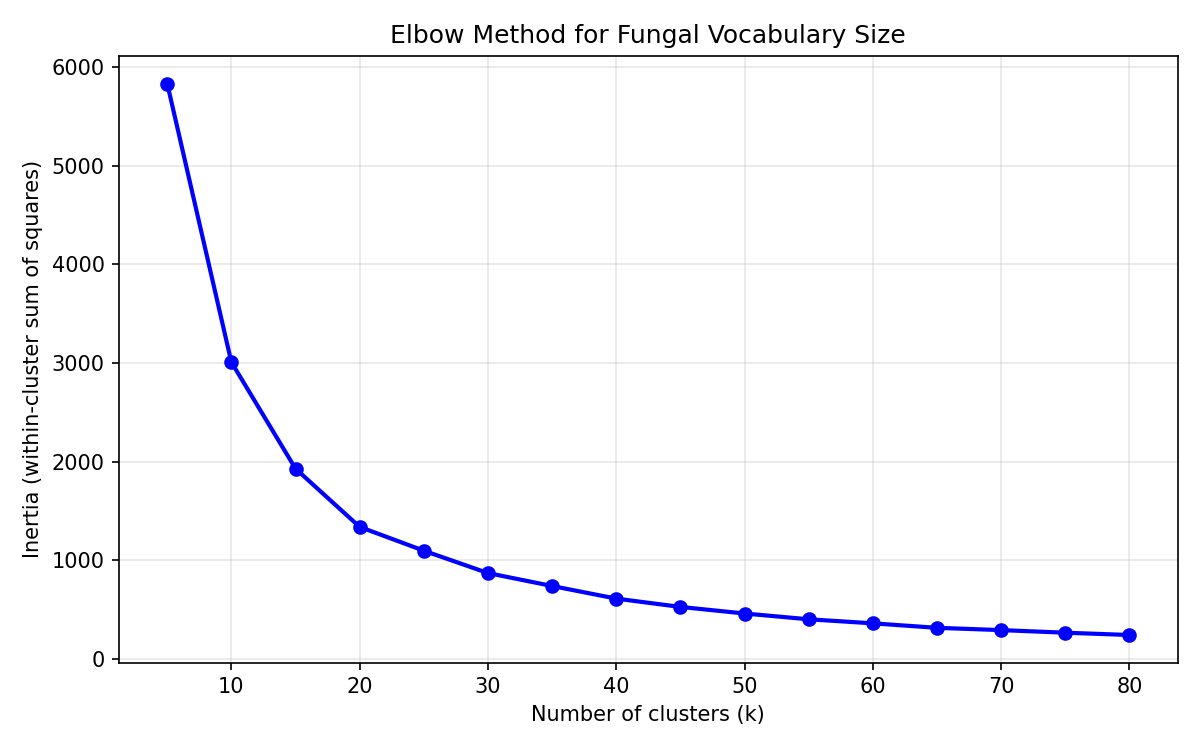

In [31]:
os.chdir('/content/EE298/software/ml')

# Elbow method — tests k=5,10,15,...,80
!python spike_vocabulary.py --elbow --max-rows 0

# Display the elbow plot
from IPython.display import Image, display
elbow_path = '/content/EE298/data/ml_results/vocabulary_elbow.png'
if os.path.exists(elbow_path):
    display(Image(filename=elbow_path, width=600))

## Cell 5c — View vocabulary analysis

FUNGAL SIGNAL VOCABULARY DISCOVERY
EE297B Research Project — SJSU

  Saved Vocabulary Stats:
  Vocabulary size: 50 word types
  Total words: 2772
  Core lexicon: 12 types
  Avg word length: 6.32 spikes
  Shannon entropy: 3.33 / 5.64 bits

  Top 10 word types:
    word_1: count=835, freq=0.301, avg_spikes=1.6, avg_amp=0.375
    word_38: count=386, freq=0.139, avg_spikes=1.5, avg_amp=0.296
    word_11: count=373, freq=0.135, avg_spikes=7.0, avg_amp=0.393
    word_13: count=369, freq=0.133, avg_spikes=2.4, avg_amp=0.143
    word_47: count=191, freq=0.069, avg_spikes=1.3, avg_amp=0.520
    word_12: count=162, freq=0.058, avg_spikes=10.4, avg_amp=0.461
    word_20: count=89, freq=0.032, avg_spikes=1.8, avg_amp=0.683
    word_22: count=49, freq=0.018, avg_spikes=3.2, avg_amp=0.581
    word_39: count=39, freq=0.014, avg_spikes=18.2, avg_amp=0.278
    word_40: count=34, freq=0.012, avg_spikes=12.5, avg_amp=0.690


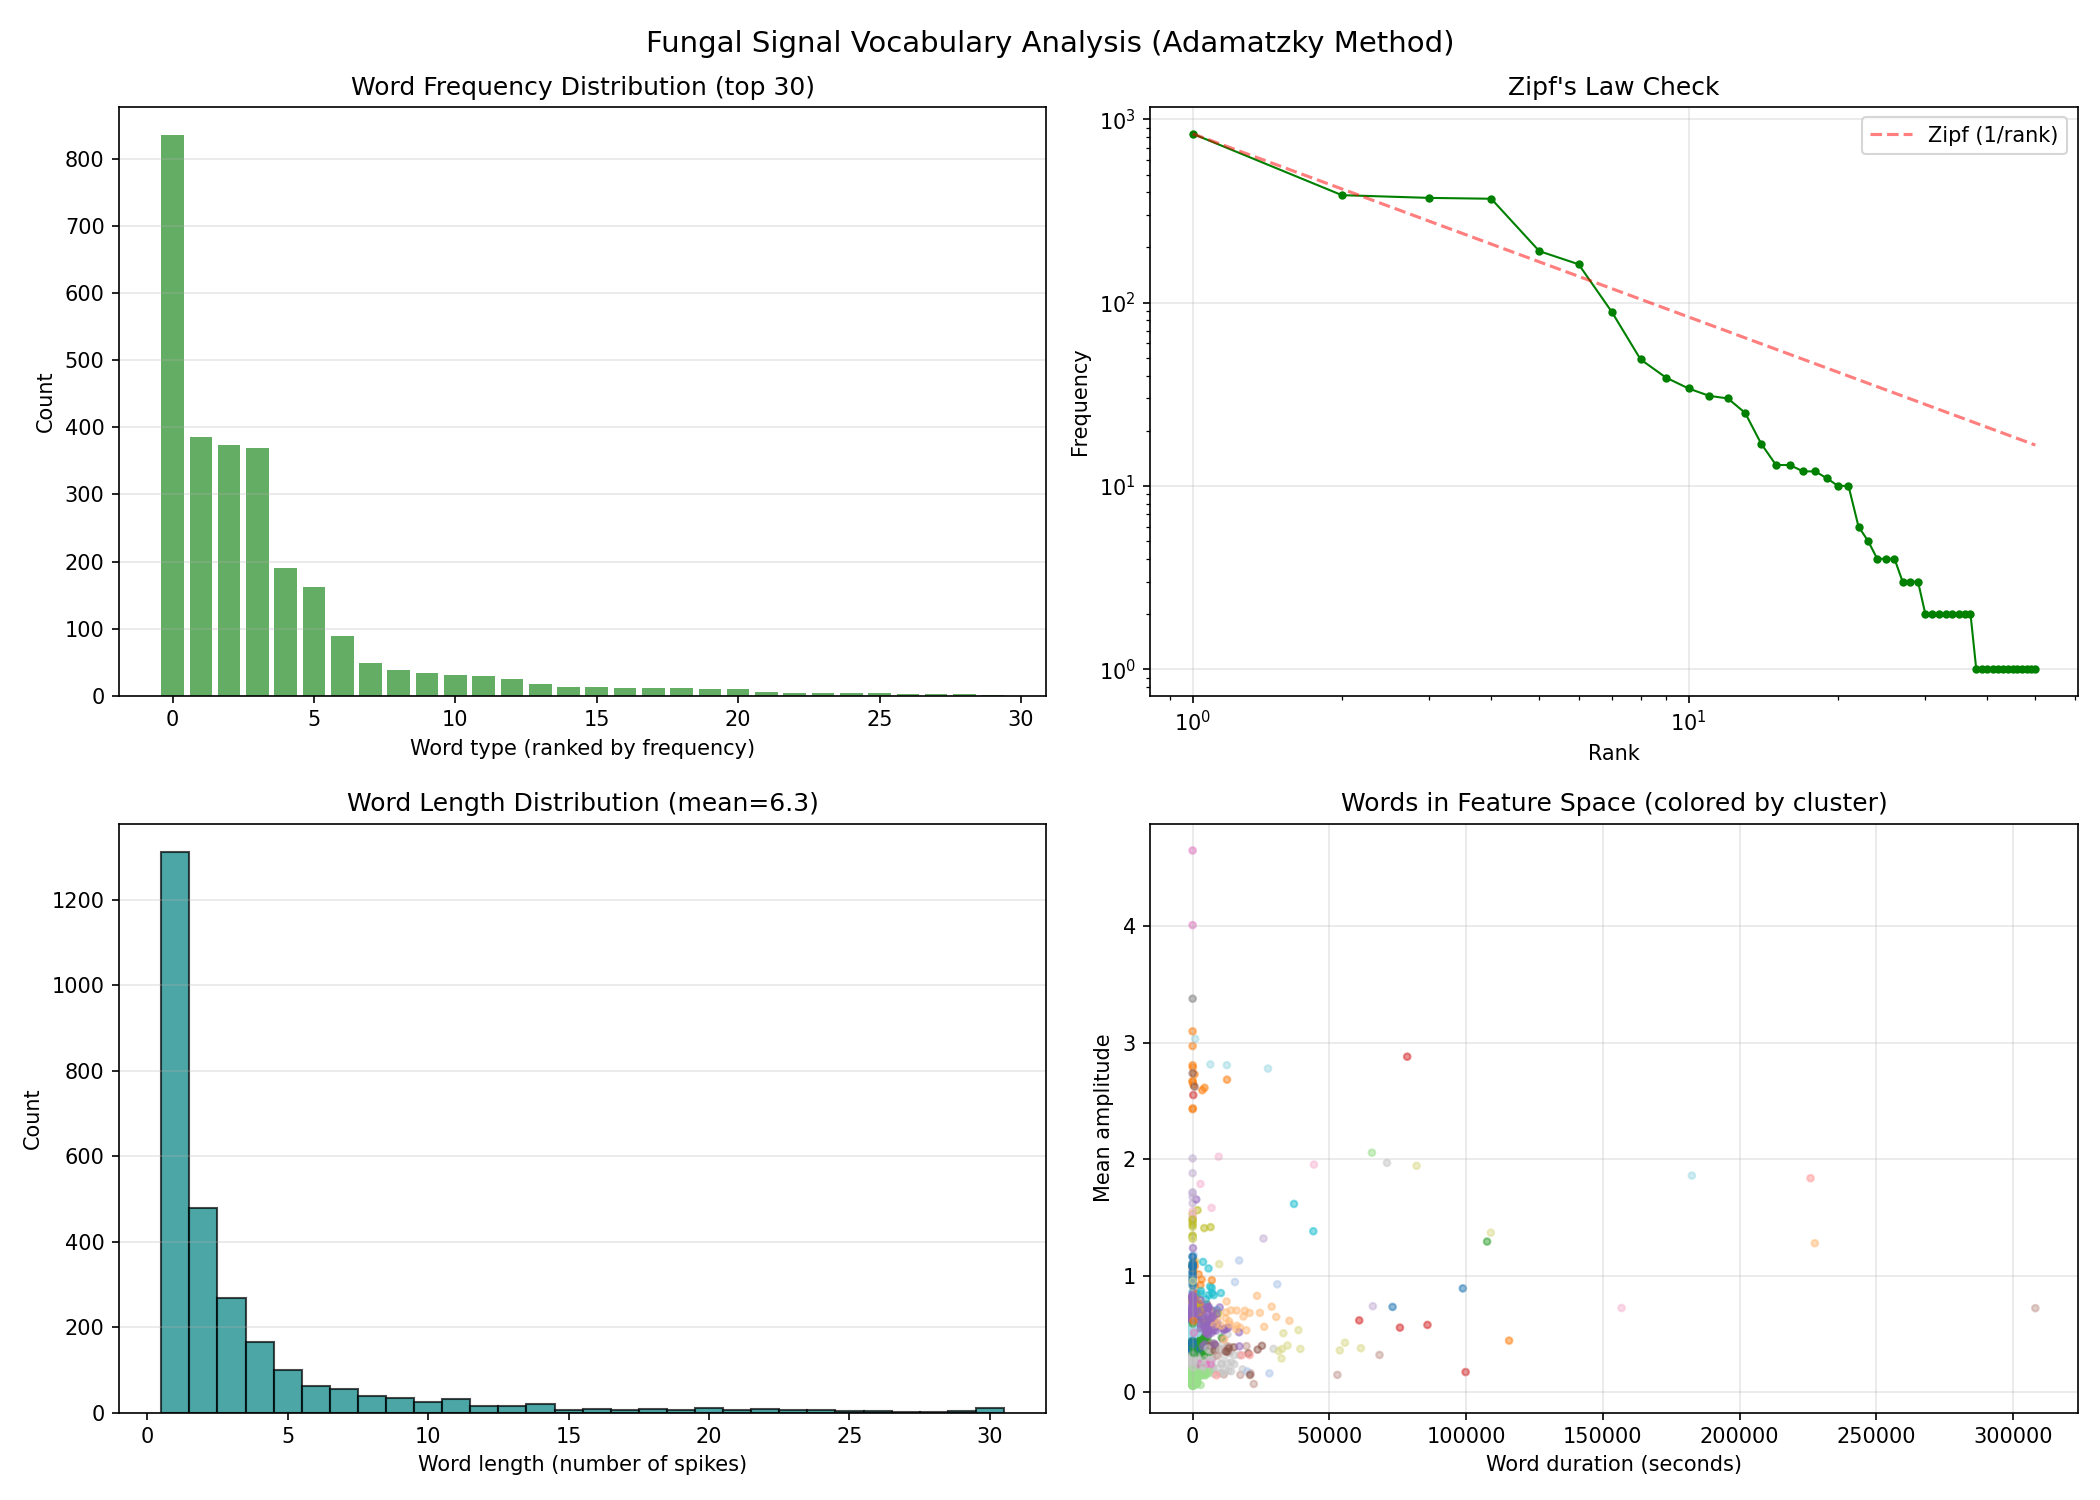

In [32]:
os.chdir('/content/EE298/software/ml')

# Show vocabulary stats
!python spike_vocabulary.py --analyze

# Display the analysis plots
from IPython.display import Image, display
plot_path = '/content/EE298/data/ml_results/vocabulary_analysis.png'
if os.path.exists(plot_path):
    display(Image(filename=plot_path, width=800))

In [45]:
  !git -C /content/EE298 pull


remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 5 (delta 3), reused 5 (delta 3), pack-reused 0 (from 0)
Unpacking objects: 100% (5/5), 1023 bytes | 341.00 KiB/s, done.
From https://github.com/theeanthony/EE298
   c685a2f..68df8a8  main       -> origin/main
Updating c685a2f..68df8a8
Fast-forward
 software/ml/train_tcn.py | 9 ++++++++-
 1 file changed, 8 insertions(+), 1 deletion(-)


## Cell 6 — Train TCN (Vocabulary Mode, All 3 Phases)
- **Phase 1:** ECG pre-training (5-class heartbeat, ~5 min)
- **Phase 2:** Vocabulary classification (k-class word types, ~5 min)
- **Phase 3:** Stimulus response decoding (5-class: 4 stimuli + baseline, ~5 min)

Total: ~15-20 min on T4 GPU with `--full`.

In [46]:
os.chdir('/content/EE298/software/ml')

# Run all 3 phases with Colab-optimized settings
!python train_tcn.py --mode vocabulary --phase all --full

TCN 3-PHASE TRANSFER LEARNING
Mode: VOCABULARY
EE297B Research Project — SJSU
  Device: CUDA (Tesla T4)
  Power: Full (Colab)
  [   0.1s] Start: 678 MB RSS

PHASE 1: PRE-TRAIN ON ECG HEARTBEAT DATA
  Loading ECG CSVs...
    mitbih_train.csv...
    mitbih_test.csv...
  ECG data: 5442 windows, 5 classes
    Class 0: 4514 windows
    Class 1: 135 windows
    Class 2: 358 windows
    Class 3: 37 windows
    Class 4: 398 windows
  [  14.2s] After ECG data load: 835 MB RSS
  Train: 4353, Val: 1089
  Model: 52,453 total params, 52,453 trainable
  Epoch 1/20 — train_loss: 0.7488, val_loss: 0.2585, val_acc: 0.903, lr: 1.0e-03
  [  17.4s] Phase1 epoch 1: 1426 MB RSS
  Epoch 2/20 — train_loss: 0.2318, val_loss: 0.1599, val_acc: 0.966, lr: 1.0e-03
  [  18.6s] Phase1 epoch 2: 1427 MB RSS
  Epoch 3/20 — train_loss: 0.2583, val_loss: 0.4085, val_acc: 0.936, lr: 1.0e-03
  [  19.8s] Phase1 epoch 3: 1427 MB RSS
  Epoch 4/20 — train_loss: 0.1078, val_loss: 0.0723, val_acc: 0.973, lr: 1.0e-03
  [  21.1s] 

### If you want to run phases individually:
Uncomment the phase you want to run.

In [34]:
# os.chdir('/content/EE298/software/ml')

# Phase 1 only (ECG pre-training)
# !python train_tcn.py --mode vocabulary --phase 1 --full

# Phase 2 only (vocabulary classification)
# !python train_tcn.py --mode vocabulary --phase 2 --full

# Phase 3 only (stimulus response)
# !python train_tcn.py --mode vocabulary --phase 3 --full

## Cell 7 — Build Fungal Dictionary
Maps discovered word types to stimulus meanings.

In [47]:
os.chdir('/content/EE298/software/ml')

!python build_dictionary.py

FUNGAL SIGNAL DICTIONARY BUILDER
EE297B Research Project — SJSU
  Device: cuda
  Loading TCN (14 classes): /content/EE298/software/ml/models/tcn_phase2_vocabulary.pt

  Loading Buffi stimulus-labeled data...
  Loading calcimycin.hdf5 → stimulus 'calcimycin' (label=0)...
    8 channels extracted
  Loading cycloheximide.hdf5 → stimulus 'cycloheximide' (label=1)...
    8 channels extracted
  Loading sodiumazide.hdf5 → stimulus 'sodiumazide' (label=2)...
    8 channels extracted
  Loading voriconazole.hdf5 → stimulus 'voriconazole' (label=3)...
    8 channels extracted

  Stimulus-labeled data: 3808 windows
    calcimycin (label=0): 952 windows
    cycloheximide (label=1): 952 windows
    sodiumazide (label=2): 952 windows
    voriconazole (label=3): 952 windows

  Running TCN inference on 3808 windows...

  Building dictionary (1 word types detected)...

  Dictionary saved: /content/EE298/software/ml/models/fungal_dictionary.json

  FUNGAL DICTIONARY — 1 word types
  Word     Count    Pri

## Cell 7b — View the dictionary

In [48]:
import json

dict_path = '/content/EE298/software/ml/models/fungal_dictionary.json'
if os.path.exists(dict_path):
    with open(dict_path) as f:
        d = json.load(f)
    print(f"Vocabulary size: {d['vocabulary_size']} word types")
    print(f"Stimuli: {d['stimuli']}")
    print()

    # Top 15 most confident word→stimulus mappings
    words = sorted(d['words'].items(), key=lambda x: x[1]['confidence'], reverse=True)
    print(f"{'Word':<10} {'Occurrences':<14} {'Primary Stimulus':<20} {'Confidence':<12} {'Interpretation'}")
    print('-' * 90)
    for wtype, info in words[:15]:
        print(f"word_{wtype:<5} {info['total_occurrences']:<14} {info['primary_stimulus']:<20} "
              f"{info['confidence']:<12.3f} {info['interpretation']}")
else:
    print("Dictionary not found — run Cell 7 first")

Vocabulary size: 1 word types
Stimuli: ['calcimycin', 'cycloheximide', 'sodiumazide', 'voriconazole']

Word       Occurrences    Primary Stimulus     Confidence   Interpretation
------------------------------------------------------------------------------------------
word_13    3808           calcimycin           0.250        Calcium ionophore stress response


## Cell 8 — Download results to your Mac
Downloads the trained models and dictionary so you can use them locally.

In [49]:
import shutil

# Zip up the results
results_dir = '/content/EE298/software/ml/models'
plots_dir = '/content/EE298/data/ml_results'

# Create a zip with all outputs
!cd /content/EE298 && zip -r /content/vocabulary_results.zip \
    software/ml/models/tcn_phase1_ecg.pt \
    software/ml/models/tcn_phase2_vocabulary.pt \
    software/ml/models/tcn_phase3_stimulus.pt \
    software/ml/models/vocabulary_kmeans.joblib \
    software/ml/models/vocabulary_scaler.joblib \
    software/ml/models/vocabulary_labels.npz \
    software/ml/models/fungal_dictionary.json \
    data/ml_results/ \
    2>/dev/null

zip_size = os.path.getsize('/content/vocabulary_results.zip') / (1024*1024)
print(f"\nResults zip: {zip_size:.1f} MB")
print("\nFiles included:")
!zipinfo -1 /content/vocabulary_results.zip

# Auto-download in Colab browser
try:
    from google.colab import files
    files.download('/content/vocabulary_results.zip')
except ImportError:
    print("\nNot running in Colab browser — manually download:")
    print("  /content/vocabulary_results.zip")

updating: software/ml/models/vocabulary_kmeans.joblib (deflated 68%)
updating: software/ml/models/vocabulary_scaler.joblib (deflated 22%)
updating: data/ml_results/ (stored 0%)
updating: data/ml_results/vocabulary_elbow.png (deflated 14%)
updating: data/ml_results/vocabulary_stats.json (deflated 79%)
updating: data/ml_results/vocabulary_analysis.png (deflated 12%)
updating: software/ml/models/tcn_phase1_ecg.pt (deflated 14%)
updating: software/ml/models/vocabulary_labels.npz (deflated 1%)
  adding: software/ml/models/tcn_phase2_vocabulary.pt (deflated 14%)
  adding: software/ml/models/tcn_phase3_stimulus.pt (deflated 14%)
  adding: software/ml/models/fungal_dictionary.json (deflated 53%)
  adding: data/ml_results/tcn_stimulus_results.png (deflated 13%)

Results zip: 149.9 MB

Files included:
software/ml/models/vocabulary_kmeans.joblib
software/ml/models/vocabulary_scaler.joblib
data/ml_results/
data/ml_results/vocabulary_elbow.png
data/ml_results/vocabulary_stats.json
data/ml_results/v

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Cell 9 (optional) — Also run the binary baseline for comparison

In [50]:
os.chdir('/content/EE298/software/ml')

# Binary mode (original smoke detector)
# !python train_tcn.py --mode binary --phase all --full

# Classical ML baseline
# !python train.py --full